# Detect product categories

## EDA

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models
from torch.optim import lr_scheduler 
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F

seed = torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
# unzip image file
local_zip = '/content/drive/MyDrive/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/dataset')
zip_ref.close()

In [4]:
base_path = '/content/drive/MyDrive/dataset'

In [5]:
# set tranformations for images

transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.CenterCrop(224), # input size of resnet50 is 224X224X3
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], 
                                                    [0.5,0.5,0.5]),
                                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                transforms.RandomRotation(degrees=(0, 180))])


train_data = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/dataset/trainset', transform = transform)


In [6]:
len(train_data)

9990

In [7]:
train_data.targets.count(8)

1000

In [8]:
# First we pick 4000 random indices from train dataset to sample data for training 
# then we split it into two parts, for training dataset and validation dataset

indices = torch.randperm(len(train_data))[:4000]

valid_size = 0.2
sample_train = len(indices)

split = int(np.floor(valid_size * sample_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(f'sample train : {len(indices)}')
print(f'train : {len(train_idx)}')
print(f'validaiton : {len(valid_idx)}')

sample train : 4000
train : 3200
validaiton : 800


In [9]:
train_sampler = torch.utils.data.Subset(train_data, train_idx) 
valid_data = torch.utils.data.Subset(train_data, valid_idx)

In [10]:
num_epoch = 5
batch_size_train = 32
batch_size_valid = 10
batch_size_test = 32
learning_rate= 0.001

In [11]:
train_loader = torch.utils.data.DataLoader(train_sampler, batch_size = batch_size_train, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_valid, shuffle = False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, shuffle = False)

print(f'length of train_dataset is : {len(train_data)} and length of sampler is : {len(train_sampler)} and length of train_loader is : {len(train_loader)}')
print(f'length of valid_dataset is : {len(valid_data)} and length of valid_loader is : {len(valid_loader)}')
# print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 9990 and length of sampler is : 3200 and length of train_loader is : 100
length of valid_dataset is : 800 and length of valid_loader is : 80


In [12]:
example = iter(train_loader)
image, label = example.next()

print(f'eamples shape : {image.shape} ,labels shape : {label.shape}')

eamples shape : torch.Size([32, 3, 224, 224]) ,labels shape : torch.Size([32])


## Train the model

Let's use vgg16 for our classification. First we should load whole of the mdoel, then we should change last classification layer of this model.

In [13]:
#Load a pretrained model and reset final fully connected layer.

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

As we can see, in the last layer we have out_features=1000, we should change it and set it to the number of classes we have (10).

In [15]:
print(list(list(model.classifier.children())[1].parameters()))

mod = list(model.classifier.children())
mod.pop() # pop last layer, then change it and append it

# we should change last layer of classifier to set the number of classes
# vgg16 don't have fc property(for example resnet18 has fc property) and it has classifier property
mod.append(torch.nn.Linear(4096, 10))
new_classifier = torch.nn.Sequential(*mod)

model.classifier = new_classifier

[]


In [18]:
mod

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [17]:
new_classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda')

In [22]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=2, gamma=0.1)

n_total_step = len(train_loader)

In [23]:
model = model.to(device)
criterion = criterion.to(device)

In [24]:
# Define a funciton to calculate accuracy for multi class classification model
def multi_class_acc(y_pred, y_act):

  y_pred_softmax = torch.softmax(y_pred, 1)
  _, y_pred_tag = torch.max(y_pred_softmax,1)

  correct = (y_pred_tag == y_act).float()  # Show which elements are the same with 1
  acc = correct.sum()/len(correct)
  acc = torch.round(acc * 100)

  return acc

In [26]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model')

In [39]:
# %reload_ext tensorboard
# %tensorboard --logdir 'model'

In [29]:
# define a function for training a model
def train(model1, train_loader):
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  
  # train the model
  model1.train()

  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)

  for i , (img, label) in loop:
    img = img.to(device)
    label = label.to(device)

    y_pred = model(img)
    
    loss_train = criterion(y_pred, label)
    acc_train = multi_class_acc(y_pred, label)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    
    optimizer.zero_grad()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()

    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)

  return train_loss, train_acc


# define a function for evaluating model
def evaluate(model1, valid_loader):

  # validation
  with torch.no_grad():
    model1.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0

    for img_val, label_val in valid_loader:

      img_val = img_val.to(device)
      label_val = label_val.to(device)

      y_pred_val = model1(img_val)
      loss_valid = criterion(y_pred_val, label_val)
      acc_valid = multi_class_acc(y_pred_val, label_val) 

      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()
    
    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader)) 

  return valid_loss, valid_acc

In [30]:
from tqdm import tqdm

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epoch):

  train_loss, train_acc = train(model, train_loader)
  writer.flush() 
  valid_loss, valid_acc = evaluate(model, valid_loader) 

  scheduler.step()


In [31]:
torch.save(model, '/content/drive/MyDrive/ModelDigi') # model1 with 5 epochs

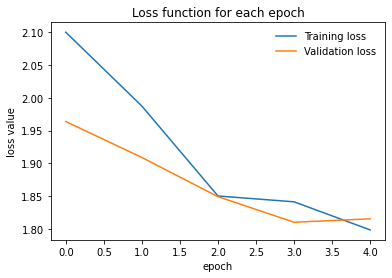

In [32]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()

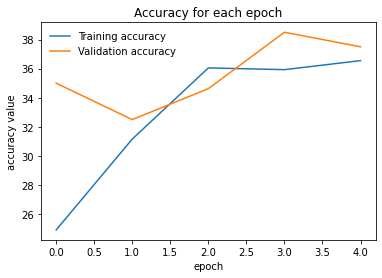

In [33]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

## Try model on the testset

In the beginning, we define some transforms for our testset images.

In [34]:
transform_pred = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224), # input size of resnet18 is 224X224X3
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], 
                                                    [0.5,0.5,0.5]),
                                transforms.RandomRotation(degrees=(0, 180))])

Let's define a function to predict the label of each image in the testset.

In [35]:
def predict_image(image):
    image_tensor = transform_pred(image).float()
    image_tensor = image_tensor.to(device)
    image_tensor = image_tensor.unsqueeze_(0)
    output = model(image_tensor)
    _, index = torch.max(output,1)
    obj=index.item()
     
    return obj

Let's open a image for example.

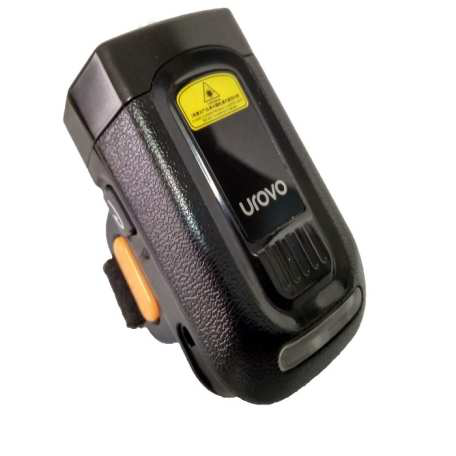

In [37]:
im=Image.open('/content/drive/MyDrive/dataset/trainset/1/01355de017e33232538f31b2dac5e4a9064d57ce_1623839690.jpg')
im

We shoudl use model.eval() before performing it on the testset, because we should test it on the testset and we don't want to update it's weight or something like that.

In [38]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
image_test = []
label_test = []

for file in os.listdir(os.path.join(base_path,'testset')):
  image_test.append(file)
  im=Image.open(os.path.join('/content/drive/MyDrive/dataset/testset', file))
  label_test.append(predict_image(im))


Save image name and it's label into CSV file.

In [41]:
result = pd.DataFrame({'name': image_test, 'predicted':label_test})

result.to_csv('result.csv', index=False)

In [ ]:
len(label_test)

9992

In [42]:
len(image_test)

9992

In [43]:
df = pd.read_csv('result.csv')
df.head()

,name,predicted
0,ce5dc12eab40007cbe3917033c07644dc8b4d28e_16235...,0
1,4d7e64564c33aed36552b449ae95cb4a060bb1ea_16147...,4
2,3b0014e0a00e3709a0ff6f4195e148f376b5481f_16291...,1
3,f68400472dfb714cab61e32fd20972952d693fc9_16278...,9
4,6802f384e3cf0a84a6d41f71507ccd9d3b5b9dd6_16204...,0
